In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256 #all of the images are 256 x 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset)

68

- There are total 68 elements in our whole dataset.
- Each element contains 32 images in them of size 256 x 256.

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


- As you can see above, each element in the dataset is a tuple. 
- First row is depicting a batch of 32 images. 
- Second row is depicting their corresponding class labels.

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch[0].shape)

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]
(256, 256, 3)


This is our first image of first batch and its corresponding shape. 
As it is a RGB image, therefore number of channels = 3.

## Image Visualization

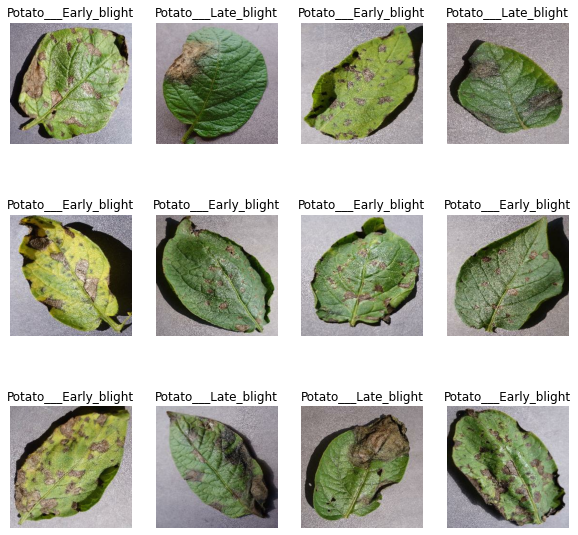

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Train Test Split

Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training (around 80%)
- Validation: Dataset to be tested against while training (around 10%)
- Test: Dataset to be tested against after we trained a model (around 10%)

In [11]:
len(dataset)

68

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

So now we have 
- train data = 54 batches and each batch has 32 images of size 256x256x3
- validation data = 6 batches and each batch has 32 images of size 256x256x3
- test data = 8 batches and each batch has 32 images of size 256x256x3

## Model Building

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomZoom(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

## Model Architecture

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 30, 30, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
model_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 67s 1s/step - loss: 0.9130 - accuracy: 0.4589 - val_loss: 0.8131 - val_accuracy: 0.7552
Epoch 2/50
54/54 [==============================] - 66s 1s/step - loss: 0.7485 - accuracy: 0.6420 - val_loss: 0.6498 - val_accuracy: 0.7143
Epoch 3/50
54/54 [==============================] - 68s 1s/step - loss: 0.6172 - accuracy: 0.7072 - val_loss: 0.5572 - val_accuracy: 0.7396
Epoch 4/50
54/54 [==============================] - 67s 1s/step - loss: 0.4640 - accuracy: 0.7911 - val_loss: 0.3101 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 66s 1s/step - loss: 0.3882 - accuracy: 0.8486 - val_loss: 0.2627 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 67s 1s/step - loss: 0.2595 - accuracy: 0.9085 - val_loss: 0.6174 - val_accuracy: 0.8281
Epoch 7/50
54/54 [==============================] - 66s 1s/step - loss: 0.2217 - accuracy: 0.9090 - val_loss: 0.2393 - val_accuracy: 0.9062
Epoch 8/50
54/54 [==

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 170ms/step - loss: 0.0536 - accuracy: 0.9844


In [29]:
scores

[0.05356431379914284, 0.984375]

In [31]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

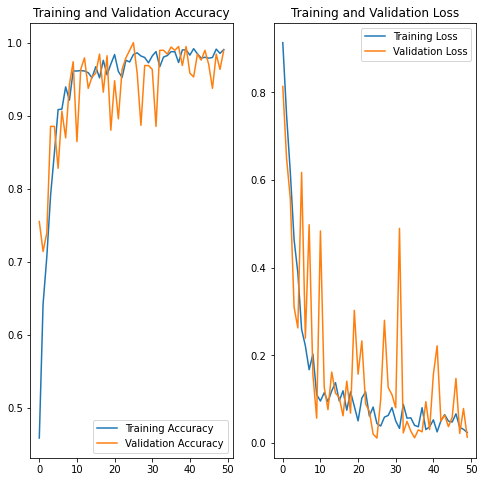

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


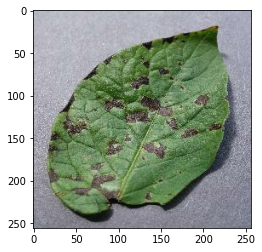

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

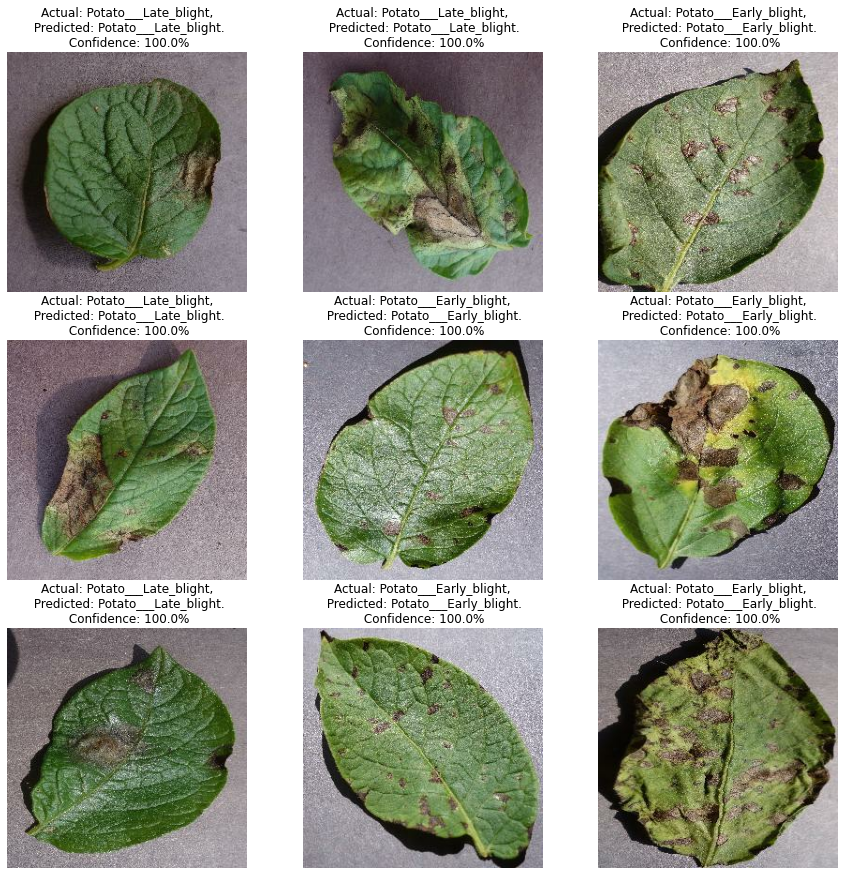

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [49]:
model_version =1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


In [50]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model\assets


In [51]:
model.save("mymodel.h5")

In [52]:
model.save(os.path.join("./dnn/","pot_model.h5"))

In [ ]:
def predict_image(img):
    img_3d = img.reshape(-1,256,256,3)
    im_resize = img_3d
    prediction = model.predict(im_resize)[0]
    return {class_name[i]: float(prediction[i]) for i in range(3)}

In [53]:
!pip install gradio

  Using cached pandas-1.4.1-cp38-cp38-win_amd64.whl (10.6 MB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=27e50c09feb32cf45f72399fa69bbb71eae673019cc57f78c566ff12137745f1
  Stored in directory: c:\users\arjun\appdata\local\pip\cache\wheels\ff\5b\59\913b443e7369dc04b61f607a746b6f7d83fb65e2e19fcc958d
Successfully built ffmpy


In [55]:
import gradio as gr

In [56]:
image = gr.inputs.Image(shape=(256,256))
label = gr.outputs.Label(num_top_classes=3)

In [ ]:
gr.Interface(fn=predict, inputs=image, outputs=label, capture_session=True).launch(debug='True')

C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\gradio\interface.py:248: UserWarning: The `capture_session` parameter in the `Interface` is deprecated and may be removed in the future.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\gradio\routes.py", line 265, in predict
    output = await run_in_threadpool(app.launchable.process_api, body, username)
  File "C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\starlette\concurrency.py", line 39, in run_in_threadpool
    return await anyio.to_thread.run_sync(func, *args)
  File "C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\anyio\to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\anyio\_backends\_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\anyio\_backends\_asyncio.py", line 754, in run
    result = context.run(func, *args)
  File "C:\Users\arjun\anaconda3\envs\potatoe\lib\site-packages\gradio\interface.py", line 574, 